# Setup

## Imports

In [1]:
from IPython.display import clear_output

!pip3 install pyprind

clear_output()

In [2]:
import cv2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as poly

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import gzip

import os
import glob
import time
import random
import json
import copy
import pyprind
import tqdm
import itertools
import pickle as pkl
from dataclasses import dataclass, field
from typing import Union, List, Dict, Any, Optional, cast

import torch
import torchvision

from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Utility

In [3]:
def one_hot(x, num_classes=2):
    return torch.nn.functional.one_hot(x, num_classes=num_classes).squeeze(1)

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

## Arguments

In [5]:
def get_gates(gates, coefficients, image_size, channels):
    def get_mixing(coefficient, image_size, channel_size):
        def get_layer(coefficient, image_size):
            total = image_size**2
            pure = int(coefficient*total)
            random = total - pure
            t = torch.cat((torch.ones((pure,)), torch.zeros((random,))), dim=0)
            idx = torch.randperm(t.nelement())
            t = t.view(-1)[idx].view(1, image_size, image_size)
            return t
        return torch.cat([get_layer(coefficient, image_size) for _ in range(channel_size)], dim=0)
    gating = []
    for i in range(len(gates)):
        gating.append((gates[i], get_mixing(coefficients[i], image_size, channels[i])))
    return tuple(gating)

def get_exposure(channel_size, k):
    return tuple(torch.where(torch.rand(channel_size, 2**k)>0.5, torch.ones(1,), torch.zeros(1,)).tolist())

In [6]:
@dataclass
class TrainingArgs():

    seed: int = 1
    lr: float = 1e-4
    batch_size: int = 100
    num_workers: int = os.cpu_count()
    max_epochs: str = 100
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    size: int = int(1e4)
    bound: int = 10
    input_size: int = 784
    output_size: int = 1
    num_classes: int = 2
    image_size: int = 28
    channels: tuple = (64, 64, 64, 64)
    use_bias: bool = False
    k: int = 1
    beta: int = 1
    weights: torch.Tensor = None
    mixing: float = (0.5, 0.5, 0.5, 0.5)
    gates: tuple = ('AND', 'AND', 'AND', 'AND')
    gating: tuple = get_gates(gates, mixing, image_size, channels)
    architecture: str = 'DNN'
    mode: str = 'Random'
    exposure: tuple = get_exposure(len(channels), k)

    data: tuple = None

    root_dir: str = './data/cifar-10'
    checkpoint: str = './checkpoints'
    experiment: str = None

args = TrainingArgs()

# Data

In [7]:
dataset = torchvision.datasets.FashionMNIST(root='/content/', train=True, transform=transforms.Compose([transforms.PILToTensor(), transforms.Lambda(lambda x: torch.flatten(x))]), download=True)

idx1 = torch.as_tensor(dataset.targets) == 1
idx2 = torch.as_tensor(dataset.targets) == 7

trainset1 = torch.utils.data.dataset.Subset(dataset, np.where(idx1==1)[0])
trainset2 = torch.utils.data.dataset.Subset(dataset, np.where(idx2==1)[0])

clear_output()

In [8]:
dataset = torchvision.datasets.FashionMNIST(root='/content/', train=False, transform=transforms.Compose([transforms.PILToTensor(), transforms.Lambda(lambda x: torch.flatten(x))]), download=True)

idx1 = torch.as_tensor(dataset.targets) == 1
idx2 = torch.as_tensor(dataset.targets) == 7

testset1 = torch.utils.data.dataset.Subset(dataset, np.where(idx1==1)[0])
testset2 = torch.utils.data.dataset.Subset(dataset, np.where(idx2==1)[0])

clear_output()

# Models

## DNN

In [9]:
class DNN(nn.Module):
    def __init__(self, args):
        super(DNN, self).__init__()
        self.args = args

        self.fc1 = nn.Linear(in_features=self.args.input_size, out_features=self.args.channels[0], bias=self.args.use_bias)
        self.fc2 = nn.Linear(in_features=self.args.channels[0], out_features=self.args.channels[1], bias=self.args.use_bias)
        self.fc3 = nn.Linear(in_features=self.args.channels[1], out_features=self.args.channels[2], bias=self.args.use_bias)
        self.fc4 = nn.Linear(in_features=self.args.channels[2], out_features=self.args.output_size, bias=self.args.use_bias)

        self.act = nn.ReLU(inplace=True)

    def forward(self, x, gate):

        out = self.fc1(x)
        out = self.act(out)

        out = self.fc2(out)
        out = self.act(out)

        out = self.fc3(out)
        out = self.act(out)

        out = self.fc4(out)
    
        return out

## Shallow

In [10]:
class Shallow(torch.nn.Module):
    def __init__(self, args):
        super(Shallow, self).__init__()
        self.args = args
        
        
        self.act1f = torch.where(torch.rand((self.args.num_classes, self.args.channels[0]))>0.5, torch.ones(1,), torch.zeros(1,)).to(self.args.device)
        self.fc1v = nn.Linear(in_features=self.args.input_size, out_features=self.args.channels[0], bias=self.args.use_bias)

        self.act2f = torch.where(torch.rand((self.args.num_classes, self.args.channels[1]))>0.5, torch.ones(1,), torch.zeros(1,)).to(self.args.device)
        self.fc2v = nn.Linear(in_features=self.args.channels[0], out_features=self.args.channels[1], bias=self.args.use_bias)
        
        self.act3f = torch.where(torch.rand((self.args.num_classes, self.args.channels[2]))>0.5, torch.ones(1,), torch.zeros(1,)).to(self.args.device)
        self.fc3v = nn.Linear(in_features=self.args.channels[1], out_features=self.args.channels[2], bias=self.args.use_bias)

        self.fc4v = nn.Linear(in_features=self.args.channels[2], out_features=self.args.output_size, bias=self.args.use_bias)

        self.gap = nn.AvgPool2d(kernel_size=32, stride=1, padding=0, ceil_mode=False)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, gate):

        preact = torch.stack([self.act1f[gate[i], :] for i in range(len(gate))])
        out = self.fc1v(x) * preact

        preact = torch.stack([self.act2f[gate[i], :] for i in range(len(gate))])
        out = self.fc2v(out) * preact

        preact = torch.stack([self.act3f[gate[i], :] for i in range(len(gate))])
        out = self.fc3v(out) * preact

        out = self.fc4v(out)

        return out

## DLGN

In [11]:
def complement(x):
    return torch.ones_like(x) - x

def AND_gate(x):
    t = torch.cat([y.unsqueeze(0) for y in x], dim=0)
    t = torch.prod(t, dim=0)
    return t

def OR_gate(x):
    if len(x) > 2:
        y = [OR_gate(x[0:2])]
        y.extend(x[2:])
        return OR_gate(y)
    if len(x) == 2:
        t = torch.cat([y.unsqueeze(0) for y in x], dim=0)
        t = torch.prod(complement(t), dim=0)
        t = complement(t)
        return t
    if len(x) == 1:
        return x[0]

def process_AND(x):
    if len(x) > 1:
        t = process_AND(x[1:])
        out = [x[0]*e for e in t]
        out.extend([complement(x[0])*e for e in t])
        return out
    elif len(x) == 1:
        return [x[0], complement(x[0])]

def process_OR(x):
    out = OR_gate(x)
    return out

def gate(x, exposure, gating=['ALL', None]):
    if gating[0] == 'OR':
        return OR_gate(x)
    if gating[0] == 'AND':
        return AND_gate(x)
    elif gating[0] == 'ALL':
        if len(x) > 2:
            t = x
            t = process_AND(x)
            t = list(itertools.compress(t, exposure))
            t = process_OR(t)
            return t
        else:
            return x[0]
    elif gating[0] == 'MIX':
        pure = [t * gating[1].to(t.device) for t in x]
        random = [t * complement(gating[1]).to(t.device) for t in x]
        pure = gate(pure, None, gating=['AND', None])
        random = gate(random, exposure, gating=['ALL', None])
        return gate([pure, random], None, gating=['OR', None])

class DLGN(torch.nn.Module):
    def __init__(self, args):
        super(DLGN, self).__init__()
        self.args = args
        
        self.fc0f = nn.ModuleList([nn.Linear(in_features=self.args.input_size, out_features=self.args.channels[0], bias=True) for _ in range(self.args.k)])
        self.fc0v = nn.Linear(in_features=self.args.input_size, out_features=self.args.channels[0], bias=True)

        self.fc1f = nn.ModuleList([nn.Linear(in_features=self.args.channels[0], out_features=self.args.channels[1], bias=True) for _ in range(self.args.k)])
        self.fc1v = nn.Linear(in_features=self.args.channels[0], out_features=self.args.channels[1], bias=True)
        
        self.fc2f = nn.ModuleList([nn.Linear(in_features=self.args.channels[1], out_features=self.args.channels[2], bias=True) for _ in range(self.args.k)])
        self.fc2v = nn.Linear(in_features=self.args.channels[1], out_features=self.args.channels[2], bias=True)

        self.fc3f = nn.ModuleList([nn.Linear(in_features=self.args.channels[2], out_features=self.args.channels[3], bias=True) for _ in range(self.args.k)])
        self.fc3v = nn.Linear(in_features=self.args.channels[2], out_features=self.args.channels[3], bias=True)

        self.fc4v = nn.Linear(in_features=self.args.channels[3], out_features=self.args.output_size, bias=True)

        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, gates):
        
        k_preact = [fc0f(x) for i, fc0f in enumerate(self.fc0f)]
        preact = gate([self.sigmoid(self.args.beta*t) for t in k_preact], self.args.exposure[0], self.args.gating[0])
        subnetwork = preact
        out = self.fc0v(x) * preact

        k_preact = [fc1f(k_preact[i]) for i, fc1f in enumerate(self.fc1f)]
        preact = gate([self.sigmoid(self.args.beta*t) for t in k_preact], self.args.exposure[1], self.args.gating[1])
        subnetwork = torch.cat((subnetwork, preact), dim=1)
        out = self.fc1v(out) * preact

        k_preact = [fc2f(k_preact[i]) for i, fc2f in enumerate(self.fc2f)]
        preact = gate([self.sigmoid(self.args.beta*t) for t in k_preact], self.args.exposure[2], self.args.gating[2])
        subnetwork = torch.cat((subnetwork, preact), dim=1)
        out = self.fc2v(out) * preact

        k_preact = [fc3f(k_preact[i]) for i, fc3f in enumerate(self.fc3f)]
        preact = gate([self.sigmoid(self.args.beta*t) for t in k_preact], self.args.exposure[3], self.args.gating[3])
        subnetwork = torch.cat((subnetwork, preact), dim=1)
        out = self.fc3v(out) * preact

        out = self.fc4v(out)

        return out

In [12]:
def compute_gradients(z, model):
    grads = []
    for t in z:
        grad_ = torch.autograd.grad(t, model.parameters(), create_graph=True, allow_unused=True)
        grad_ = [t.reshape(-1) for t in grad_]
        grad_ = torch.cat(grad_, dim=0)
        grads.append(grad_.unsqueeze(0))
    grads = torch.cat(grads, dim=0)
    return grads

# Train

In [37]:
# model = DNN(args).to(args.device)
# model = Shallow(args).to(args.device)
model = DLGN(args).to(args.device)

optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
criterion = nn.MSELoss()

I = torch.eye(2*args.batch_size).to(args.device)

In [38]:
assert len(testset1)==len(testset2)
size=len(testset1)//2
testloader1 = torch.utils.data.DataLoader(testset1, batch_size=size, shuffle=False)
testloader2 = torch.utils.data.DataLoader(testset2, batch_size=size, shuffle=False)
it_t1 = iter(testloader1)
it_t2 = iter(testloader2)

I = torch.eye(2*size).to(args.device)

x1, _ = next(it_t1)
x1, y1 = x1.float(), torch.ones((x1.size(0), 1))*-1
x2, _ = next(it_t2)
x2, y2 = x2.float(), torch.ones((x2.size(0), 1))

x_test = torch.cat((x1, x2), dim=0).to(args.device)
y_test = torch.cat((y1, y2), dim=0).to(args.device)
gates_test = [0]*x1.size(0) + [1]*x2.size(0)

In [39]:
assert len(trainset1)==len(trainset2)
size = len(trainset1)
trainloader1 = torch.utils.data.DataLoader(trainset1, batch_size=args.batch_size)
trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=args.batch_size)

In [40]:
cache = {'e': [], 'k_t': [], 'e_dash': []}

z_test = model(x_test, gates_test)
e = z_test - y_test
e_dash = e.cpu()
cache['e'].append(e.cpu())
cache['e_dash'].append(e_dash.cpu())

for epoch in range(1, args.max_epochs+1):
    it1 = iter(trainloader1)
    it2 = iter(trainloader2)
    accuracy = []

    model.train()
    for _ in range(len(trainloader1)):
        torch.cuda.empty_cache()

        x1, _ = next(it1)
        x1, y1 = x1.float(), torch.ones((x1.size(0), 1))*-1

        x2, _ = next(it2)
        x2, y2 = x2.float(), torch.ones((x2.size(0), 1))

        x = torch.cat((x1, x2), dim=0).to(args.device)
        y = torch.cat((y1, y2), dim=0).to(args.device)
        gates = [0]*x1.size(0) + [1]*x2.size(0)

        z = model(x, gates)

        optimizer.zero_grad()
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()

        z = torch.where(z>0, torch.ones(1,).to(args.device), -1*torch.ones(1,).to(args.device))
        accuracy.append((z==y).float().sum().item()/200)

    model.eval()
    torch.cuda.empty_cache()

    z_test = model(x_test, gates_test)

    grads = compute_gradients(z_test, model)
    k_t = torch.matmul(grads, grads.T)

    loss = criterion(z_test, y_test)
    loss.backward()

    e = z_test - y_test
    e_dash = torch.matmul(I-args.lr*k_t, cache['e_dash'][-1].to(args.device))
    cache['e'].append(e.detach().cpu())
    cache['k_t'].append(k_t.detach().cpu())
    cache['e_dash'].append(e_dash.detach().cpu())


    print(f'Epoch {epoch}/{args.max_epochs} | Accuracy: {sum(accuracy)/len(accuracy)}')

Epoch 1/100 | Accuracy: 0.9117500000000002
Epoch 2/100 | Accuracy: 0.9655833333333335
Epoch 3/100 | Accuracy: 0.9774166666666664
Epoch 4/100 | Accuracy: 0.9835833333333331
Epoch 5/100 | Accuracy: 0.9874999999999993
Epoch 6/100 | Accuracy: 0.9894999999999993
Epoch 7/100 | Accuracy: 0.990666666666666
Epoch 8/100 | Accuracy: 0.9918333333333327
Epoch 9/100 | Accuracy: 0.9927499999999995
Epoch 10/100 | Accuracy: 0.9937499999999997
Epoch 11/100 | Accuracy: 0.9940833333333331
Epoch 12/100 | Accuracy: 0.9944166666666665
Epoch 13/100 | Accuracy: 0.9949166666666664
Epoch 14/100 | Accuracy: 0.9950833333333332
Epoch 15/100 | Accuracy: 0.9954166666666666
Epoch 16/100 | Accuracy: 0.9954166666666666
Epoch 17/100 | Accuracy: 0.9956666666666667
Epoch 18/100 | Accuracy: 0.9959166666666666
Epoch 19/100 | Accuracy: 0.99625
Epoch 20/100 | Accuracy: 0.9964999999999998
Epoch 21/100 | Accuracy: 0.9969166666666666
Epoch 22/100 | Accuracy: 0.9972499999999999
Epoch 23/100 | Accuracy: 0.9973333333333334
Epoch 24/

In [41]:
a = []
b = []
for i in range(len(cache['e'])-2):
    et = cache['e'][i]
    et = et/(torch.matmul(et.T, et))
    kt = cache['k_t'][i] /torch.linalg.norm(cache['k_t'][i], ord=2) # /torch.trace(cache['k_t'][i])
    kt1 = cache['k_t'][i+1] /torch.linalg.norm(cache['k_t'][i+1], ord=2) # /torch.trace(cache['k_t'][i+1])
    a.append(torch.matmul(et.T, torch.matmul(kt, et)).item())
    b.append(torch.matmul(et.T, torch.matmul(kt1, et)).item())

a = np.array(a)
b = np.array(b)

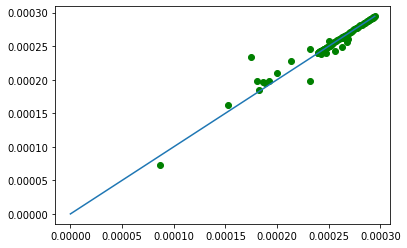

In [42]:
p = np.linspace(0, max(b), 100)

plt.plot(a, b, 'go')
plt.plot(p, p)

In [43]:
a = []
b = []
for i in range(len(cache['e'])-2):
    et = cache['e'][i]
    et = et/(torch.matmul(et.T, et))
    kt = cache['k_t'][i] /torch.trace(cache['k_t'][i])
    kt1 = cache['k_t'][i+1] /torch.trace(cache['k_t'][i+1])
    a.append(torch.matmul(et.T, torch.matmul(kt, et)).item())
    b.append(torch.matmul(et.T, torch.matmul(kt1, et)).item())

a = np.array(a)
b = np.array(b)

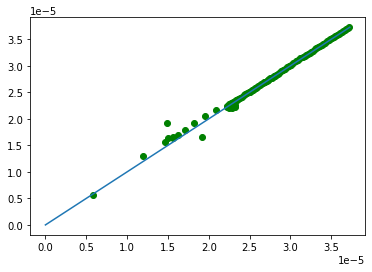

In [44]:
p = np.linspace(0, max(b), 100)

plt.plot(a, b, 'go')
plt.plot(p, p)